# Classification

## Preliminar operations

In [4]:
import numpy as np
import os
from zipfile import ZipFile
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torcheeg import models

In [5]:
# verify GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using \"{}\" device".format(device))
# !nvidia-smi

Using "cuda" device


## Loading data

**THINGS-EEG2 (subset: single subject)**

RSVP: time-efficient rapid serial visual presentation
- 1 subject
- 17 channels
- 1 second recording 100 samples (10ms or 100Hz freq)
- 1854 concepts
- 16740 images
- 82160 trials
- 27 or 53 high level categories (overlapped and missing categories)

Train:
- 1654 concepts
- 16540 images (10 images per concept)
- 66160 trial (4 rep per image)

Test:
- 200 concepts
- 200 images (1 image per concept)
- 16000 trial (80 rep per image)

In [6]:
# define the path to the data
data_path = '../data/THINGS-EEG2/'

In [16]:
eeg_train_path = os.path.join(data_path, 'preprocessed_data', 'sub-' + '04', 'preprocessed_eeg_' + 'training' + '.npy')
eeg_test_path = os.path.join(data_path, 'preprocessed_data', 'sub-' + '04', 'preprocessed_eeg_' + 'test' + '.npy')
image_metadata_path = os.path.join(data_path, 'image_metadata/image_metadata.npy')
category53_path = os.path.join(data_path, 'image_metadata/category53_longFormat.tsv')
category27_mat_path = os.path.join(data_path, 'image_metadata/category_mat_manual.tsv')

eeg_train = np.load(eeg_train_path, allow_pickle=True).item()
eeg_test = np.load(eeg_test_path, allow_pickle=True).item()
image_metadata = np.load(image_metadata_path, allow_pickle=True).item()
category53 = pd.read_csv(category53_path, sep='\t')
category27_mat = pd.read_csv(category27_mat_path, sep='\t')

In [29]:
list(1854/np.sum(category27_mat))

[10.474576271186441,
 68.66666666666667,
 54.529411764705884,
 17.166666666666668,
 48.78947368421053,
 17.65714285714286,
 50.108108108108105,
 97.57894736842105,
 25.054054054054053,
 6.284745762711864,
 54.529411764705884,
 47.53846153846154,
 41.2,
 109.05882352941177,
 92.7,
 68.66666666666667,
 68.66666666666667,
 56.18181818181818,
 74.16,
 61.8,
 39.4468085106383,
 28.96875,
 17.327102803738317,
 54.529411764705884,
 44.142857142857146,
 26.485714285714284,
 38.625]

In [23]:
np.sum(category27_mat)

animal                177
bird                   27
body part              34
clothing              108
clothing accessory     38
container             105
dessert                37
drink                  19
electronic device      74
food                  295
fruit                  34
furniture              39
home decor             45
insect                 17
kitchen appliance      20
kitchen tool           27
medical equipment      27
musical instrument     33
office supply          25
part of car            30
plant                  47
sports equipment       64
tool                  107
toy                    34
vegetable              42
vehicle                70
weapon                 48
dtype: int64

In [22]:
list(np.sum(category27_mat == 0) / np.sum(category27_mat))

[9.474576271186441,
 67.66666666666667,
 53.529411764705884,
 16.166666666666668,
 47.78947368421053,
 16.65714285714286,
 49.108108108108105,
 96.57894736842105,
 24.054054054054053,
 5.284745762711864,
 53.529411764705884,
 46.53846153846154,
 40.2,
 108.05882352941177,
 91.7,
 67.66666666666667,
 67.66666666666667,
 55.18181818181818,
 73.16,
 60.8,
 38.4468085106383,
 27.96875,
 16.327102803738317,
 53.529411764705884,
 43.142857142857146,
 25.485714285714284,
 37.625]

In [8]:
n_images, n_repetitions, n_channels, n_times = eeg_train['preprocessed_eeg_data'].shape
eeg_reshaped = eeg_train['preprocessed_eeg_data'].reshape((-1, n_channels, n_times))
eeg_train['preprocessed_eeg_data'].shape, eeg_reshaped.shape

((16540, 4, 17, 100), (66160, 17, 100))

In [9]:
eeg_reshaped[0][0]

array([ 0.4539526 ,  0.51643129,  0.60930456,  0.34861743, -0.57875437,
       -0.55656147, -0.80507541, -0.68757902, -0.21107484, -0.32593669,
       -0.26585787,  0.40421187,  0.59717525,  0.6023611 , -0.12493843,
       -1.20107749, -1.31159566, -0.34483615,  0.97501248,  1.24897328,
        1.14696591,  0.46684753,  0.01703438,  0.73561328,  0.73216587,
        0.26091281, -0.54657191, -1.16148978, -1.07541046, -0.13685725,
        1.30884009,  1.54049018,  1.01553245,  0.16726818, -0.2563653 ,
       -0.37234284,  0.12053667,  0.17917237,  0.68496869,  1.09932835,
        0.94823464,  0.49821375, -0.29542823,  0.20053896,  0.59719814,
        0.32353181,  0.20094806,  0.11625806,  0.04592397,  0.45675037,
        0.88198026,  0.8293996 ,  0.25229832, -0.27092648, -0.33948166,
       -0.1524662 , -0.28310139,  0.00259233,  0.55855998,  0.3931841 ,
        0.5283516 ,  0.77513347,  0.72502785,  0.58410304,  0.56597055,
       -0.23689939, -1.13033246, -0.95541466, -0.05806652,  0.60

In [10]:
from scipy import signal

f, t, Sxx = signal.spectrogram(eeg_reshaped[0], nperseg=100, fs=100)
f, t, Sxx = signal.spectrogram(eeg_reshaped[0][0], nperseg=20, fs=100)

Sxx.shape, f.shape, t.shape

((11, 5), (11,), (5,))

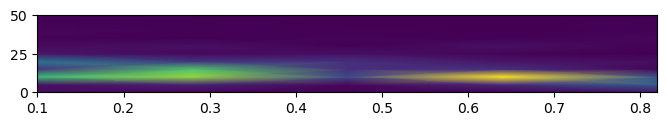

In [11]:
from matplotlib import pyplot as plt
plt.pcolormesh(t, f, Sxx, shading='gouraud', figure=plt.figure(figsize=(8, 1)))

In [12]:
np.array([[[1, 1.1], [2, 2.2]], [[3, 3.3], [4, 4.4]]]).reshape((-1, 2))

array([[1. , 1.1],
       [2. , 2.2],
       [3. , 3.3],
       [4. , 4.4]])

In [13]:
features_path = os.path.join(data_path, 'image_set_features', 'resnet18', 'training' + '_images.npy')
features = np.load(features_path, allow_pickle=True)
# features = features.reshape((-1, features.shape[-1]))

# np.repeat(features, n_repetitions, axis=0).shape

In [14]:
features.shape

(1654, 10, 1, 512)

In [12]:
from Classification_EEG_models import EEGNet

net = (EEGNet()).to('cuda')

for i in net.named_parameters():
    print(i[0], i[1].shape)

block1.0.weight torch.Size([8, 1, 1, 64])
block1.1.weight torch.Size([8])
block1.1.bias torch.Size([8])
block1.2.weight torch.Size([16, 1, 60, 1])
block1.3.weight torch.Size([16])
block1.3.bias torch.Size([16])
block2.0.weight torch.Size([16, 1, 1, 16])
block2.1.weight torch.Size([16, 16, 1, 1])
block2.2.weight torch.Size([16])
block2.2.bias torch.Size([16])
lin.weight torch.Size([2, 64])


In [50]:
# from torchvision.models import resnet50, ResNet50_Weights
# from PIL import Image
# from torchvision.models.feature_extraction import create_feature_extractor

# model = create_feature_extractor(resnet50(weights = ResNet50_Weights.DEFAULT), return_nodes={'flatten': 'flatten'}).to(device)
# model.eval()

# w = ResNet50_Weights.DEFAULT
# preprocess = w.transforms()

# part_dir = os.path.join(data_path, 'image_set', 'test_images.zip')
# with ZipFile(part_dir, 'r') as zipObj:
#     file = zipObj.open('test_images/00001_aircraft_carrier/aircraft_carrier_06s.jpg')
#     img = Image.open(file).convert('RGB')
#     input_img = preprocess(img).unsqueeze(0).to(device) # preprocess and convert to tensor

#     print(img.size)
#     input_img = preprocess(img).unsqueeze(0).to(device)
#     print(input_img.shape)

#     print(model(input_img)['flatten'].cpu().detach().numpy().shape)
#     print(np.mean(model(input_img)['flatten'].cpu().detach().numpy()))
#     print(model(input_img)['flatten'].cpu().detach().numpy())

(500, 500)
torch.Size([1, 3, 224, 224])
(1, 2048)
0.017908897
[[0.00644116 0.         0.         ... 0.         0.         0.        ]]


In [19]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights, resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

m = resnet18(weights = ResNet18_Weights.DEFAULT)
print(get_graph_node_names(m))

# model = create_feature_extractor(m, return_nodes={'avgpool': 'layer'}).to('cuda')

(['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'la

In [19]:
# tr_dir = os.path.join(data_path, 'image_set_features/resnet18/training_images.npy')
# tr = np.load(a, allow_pickle=True)
# tr.shape

(1654, 10, 1, 512)

In [26]:
# len(np.mean(tr, axis=(0,1,2)))

512

In [39]:
# from matplotlib import pyplot as plt

# sum(np.reshape(tr, (-1)) == 0)/len(np.reshape(tr, (-1))) * 100
# # sum(tr == 0)


1.6170788618500604

In [12]:
image_metadata.keys()

dict_keys(['test_img_concepts', 'test_img_concepts_THINGS', 'test_img_files', 'train_img_files', 'train_img_concepts', 'train_img_concepts_THINGS'])

In [116]:
category27_mat.sum()

dtype('int64')

### EEG signals

In [107]:
eeg_train['preprocessed_eeg_data'].shape

(16540, 4, 17, 100)

In [108]:
# n_channels = 17
# n_times = 100
# n_classes = 200

In [109]:
eeg_train_reshaped = eeg_train['preprocessed_eeg_data'].reshape((-1, 17, 100))
eeg_test_reshaped = eeg_test['preprocessed_eeg_data'].reshape((-1, 17, 100))

print(eeg_train_reshaped.shape)
print(eeg_test_reshaped.shape)

(66160, 17, 100)
(16000, 17, 100)


### Concepts

In [110]:
print(image_metadata.keys())
print(image_metadata['train_img_concepts'][:5])
print(image_metadata['train_img_concepts_THINGS'][:5])
print(image_metadata['train_img_files'][:5])

dict_keys(['test_img_concepts', 'test_img_concepts_THINGS', 'test_img_files', 'train_img_files', 'train_img_concepts', 'train_img_concepts_THINGS'])
['00001_aardvark', '00001_aardvark', '00001_aardvark', '00001_aardvark', '00001_aardvark']
['00001_aardvark', '00001_aardvark', '00001_aardvark', '00001_aardvark', '00001_aardvark']
['aardvark_01b.jpg', 'aardvark_02s.jpg', 'aardvark_03s.jpg', 'aardvark_04s.jpg', 'aardvark_05s.jpg']


In [111]:
# Get list of files names in zip
def get_concepts(partition):
    path_tmp = os.path.join(data_path, 'image_set', f'{partition}_images.zip')

    with ZipFile(path_tmp, 'r') as zipObj:
        # Get list of files names in zip
        files_list_tmp = zipObj.namelist()

    files_list_tmp.sort()
    concepts_tmp = ['_'.join(elem.split('/')[2].split('_')[: -1]) for elem in files_list_tmp if elem.endswith('/') == False]

    concepts_tmp = np.repeat(concepts_tmp, 4 if partition == 'training' else 80)

    return concepts_tmp

In [112]:
concepts_train = get_concepts('training')
concepts_test = get_concepts('test')

print(len(concepts_train))
print(len(concepts_test))

66160
16000


In [113]:
# concepts
concepts_train_int = np.repeat(np.array(range(1654)), 40)
concepts_test_int = np.repeat(np.array(range(200)), 80)

concepts_test_dict = dict(zip(concepts_test_int, concepts_test)) # dictionary with concepts
concepts_train_dict = dict(zip(concepts_train_int, concepts_train)) # dictionary with concepts

### Categories

In [114]:
# concept df
concepts = sorted(list(set(concepts_train)) + list(set(concepts_test)))
concepts_df = pd.DataFrame({'concept': concepts})
concepts_df['concept_ID'] = concepts_df.index
concepts_df.head()

,concept,concept_ID
0,aardvark,0
1,abacus,1
2,accordion,2
3,acorn,3
4,air_conditioner,4


In [115]:
# category27 df
category27_df = category27_mat[category27_mat==1].stack().reset_index().drop(0, axis=1)
category27_df.columns = ['concept_ID', 'category27']
category27_df.sort_values(by=['category27'], inplace=True)
category27_df['category27_ID'] = pd.factorize(category27_df['category27'])[0]
category27_df = category27_df.groupby('concept_ID').agg({'category27': lambda x: list(x), 'category27_ID': lambda x: list(x)}).reset_index()
category27_df.head()

,concept_ID,category27,category27_ID
0,0,[animal],[0]
1,1,[home decor],[12]
2,2,[musical instrument],[17]
3,4,[electronic device],[8]
4,5,[furniture],[11]


In [116]:
# category53 df
category53_df = category53.drop(columns='Word')
category53_df.rename(columns={'category': 'category53', 'uniqueID': 'concept'}, inplace=True)
category53_df.sort_values(by=['category53'], inplace=True)
category53_df['category53_ID'] = pd.factorize(category53_df['category53'])[0]
category53_df = category53_df.groupby('concept').agg({'category53': lambda x: list(x), 'category53_ID': lambda x: list(x)}).reset_index()
category53_df.head()

,concept,category53,category53_ID
0,aardvark,"[animal, mammal]","[0, 31]"
1,abacus,[home decor],[25]
2,accordion,[musical instrument],[33]
3,air_conditioner,"[electronic device, home appliance]","[13, 24]"
4,air_mattress,[furniture],[19]


In [117]:
# create a dataframe with the concepts and their categories
boh_df = pd.merge(left=concepts_df, right=category27_df, on='concept_ID', how='left')
boh_df = pd.merge(left=boh_df, right=category53_df, on='concept', how='left')
boh_df

,concept,concept_ID,category27,category27_ID,category53,category53_ID
0,aardvark,0,[animal],[0],"[animal, mammal]","[0, 31]"
1,abacus,1,[home decor],[12],[home decor],[25]
2,accordion,2,[musical instrument],[17],[musical instrument],[33]
3,acorn,3,NaN,NaN,NaN,NaN
4,air_conditioner,4,[electronic device],[8],"[electronic device, home appliance]","[13, 24]"
...,...,...,...,...,...,...
1849,yoke,1849,NaN,NaN,NaN,NaN
1850,yolk,1850,[food],[9],[food],[16]
1851,zebra,1851,[animal],[0],"[animal, mammal]","[0, 31]"
1852,zipper,1852,NaN,NaN,[fastener],[15]


In [118]:
boh_df['category27'].str.len().value_counts(dropna=False)

1.0    993
NaN    559
2.0    276
3.0     26
Name: category27, dtype: int64

In [119]:
boh_df['category53'].str.len().value_counts(dropna=False)

1.0    784
2.0    476
NaN    406
3.0    140
4.0     42
5.0      5
6.0      1
Name: category53, dtype: int64

## EEGNET

Test partition 200 classes
- sub01 accuracy 20%
- sub02 accuracy 15%
- sub03 accuracy 25%
- sub04 accuracy 20%

In [120]:
# parameters and model

model = models.EEGNet(chunk_size=100, num_electrodes=17, num_classes=200).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 200

In [121]:
# split
len(eeg_test_reshaped)/200

x_train_prova = []
y_train_prova = []
x_val_prova = []
y_val_prova = []

for i in range(0,80):
    if i < 20:
        x_val_prova.extend(eeg_test_reshaped[i::80])
        y_val_prova.extend(concepts_test_int[i::80])
    else:
        x_train_prova.extend(eeg_test_reshaped[i::80])
        y_train_prova.extend(concepts_test_int[i::80])

x_train_prova = np.array(x_train_prova)
x_val_prova = np.array(x_val_prova)
y_train_prova = np.array(y_train_prova)
y_val_prova = np.array(y_val_prova)

x_train_prova.shape, x_val_prova.shape

((12000, 17, 100), (4000, 17, 100))

In [122]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32)) # convert float64 to float32
    self.y = torch.from_numpy(y_train).type(torch.LongTensor) # convert float64 to Long
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  
  def __len__(self):
    return self.len

In [144]:
data_train = Data(x_train_prova, y_train_prova)
data_val = Data(x_val_prova, y_val_prova)

In [152]:
# next(iter(data_train))
# iter(data_train)


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [124]:
# dataset and dataloader
data_train = Data(x_train_prova, y_train_prova)
data_val = Data(x_val_prova, y_val_prova)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)

NameError: name 'batch_size' is not defined

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, batch in enumerate(dataloader):
        X = batch[0].to(device)
        y = batch[1].to(device)

        X = X.reshape(batch_size, 1, 17, 100)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), batch_idx * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            X = X.reshape(batch_size, 1, 17, 100)

            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Val accuracy: {(100*correct):>0.1f}%, Val avg loss: {val_loss:>8f} \n")

In [ ]:
# Training
for t in range(epochs):
    print(f"------------ Epoch {t+1} ---------------")
    train(train_loader, model, loss_fn, optimizer)
    valid(val_loader, model, loss_fn)
print("Done!")

------------ Epoch 1 ---------------


Val accuracy: 2.8%, Val avg loss: 4.905233 

------------ Epoch 2 ---------------
Val accuracy: 5.9%, Val avg loss: 4.605338 

------------ Epoch 3 ---------------
Val accuracy: 6.7%, Val avg loss: 4.453997 

------------ Epoch 4 ---------------
Val accuracy: 9.4%, Val avg loss: 4.339848 

------------ Epoch 5 ---------------
Val accuracy: 10.0%, Val avg loss: 4.251158 

------------ Epoch 6 ---------------
Val accuracy: 11.5%, Val avg loss: 4.189923 

------------ Epoch 7 ---------------
Val accuracy: 12.4%, Val avg loss: 4.144713 

------------ Epoch 8 ---------------
Val accuracy: 12.2%, Val avg loss: 4.081394 

------------ Epoch 9 ---------------
Val accuracy: 13.1%, Val avg loss: 4.056725 

------------ Epoch 10 ---------------
Val accuracy: 12.7%, Val avg loss: 4.042118 

------------ Epoch 11 ---------------
Val accuracy: 13.6%, Val avg loss: 4.022032 

------------ Epoch 12 ---------------
Val accuracy: 14.1%, Val avg loss: 4.012230 

------------ Epoch 13 ---------------
Val 